# Imports

In [24]:
# --- Basic Utilities ---
import datetime as dt
import logging
import math
import os
import re
import sys
import time
import warnings
import json
import functools
import time
from pathlib import Path

# --- Data Manipulation ---
import numpy as np
import pandas as pd

# --- Validation ---
from pydantic import BaseModel, Field, ValidationError

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex, Math

# --- Console Formatting ---
from colorama import Fore, Style

# --- Logging Framework ---
from loguru import logger
import uuid

# --- MLflow for Experiment Tracking ---
import mlflow
import mlflow.pytorch
import mlflow.sklearn
from mlflow.data import from_pandas
from mlflow.models.signature import infer_signature

# --- ONNX Runtime (Optional) ---
import onnx
import onnxruntime as ort

# Add the below onnx code to FastAPI for deployment
# @app.on_event("startup")
# def load_model():
#     global session
#     session = ort.InferenceSession(
#         "model.onnx",
#         providers=["CUDAExecutionProvider", "CPUExecutionProvider"]
#     )


# --- Scientific Computation ---
import scipy as sp
import sympy as sym
from plotly.data import experiment

# --- Scikit-Learn ---
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
)

from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    OneHotEncoder, OrdinalEncoder
)

from sklearn.linear_model import (
    LogisticRegression, ElasticNet, Ridge, Lasso
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, accuracy_score,
    mean_squared_error, mean_absolute_error, r2_score
)

# --- PyTorch Core ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

# --- Joblib for Model Serialization ---
import joblib

# --- Optional: Config Frameworks (commented) ---
# from omegaconf import OmegaConf
# import hydra


# --- Warning Filters ---
from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=TqdmWarning)
warnings.filterwarnings("ignore")

# --- Mlflow Env ---
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "false"

# --- PyTorch Runtime Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
print(f"[INFO] PyTorch version: {torch.__version__}")
torch.set_num_threads(32)

[INFO] Using device: cuda
[INFO] PyTorch version: 2.6.0+cu124


In [25]:
# --- MLflow Experiment Setup ---
experiment_name = "binary_classification_circles"
mlflow.set_experiment(experiment_name)

# --- Init MLflow Run ---

# kill unclosed run if exists
if mlflow.active_run():
    mlflow.end_run()

run = mlflow.start_run()

# --- Logging Initialization ---

# Create log directory for the experiment
log_dir = Path("/mnt/mls/logs") / experiment_name
log_dir.mkdir(parents=True, exist_ok=True)

# Define log file path
log_file = log_dir / f"train_{experiment_name}.log"
timestamp = str(dt.datetime.now(dt.timezone.utc).strftime("%Y_%m_%d_%H%M%S"))
run_id = run.info.run_id

logger.remove()

logger = logger.bind(run_id=run_id)
logger = logger.bind(run_id=run_id, timestamp=timestamp)

# File logging with daily rotation and compression
logger.add(
    str(log_file),  # Path to the log file (must be a string, not a Path object)

    format="{extra[timestamp]} | {level} | {extra[run_id]} | {name}:{function}:{line} | {message}",
    # Format of each log line:
    # {time}     - Timestamp (YYYY-MM-DD HH:MM:SS.mmm)
    # {level}    - Log level (INFO, DEBUG, etc.)
    # {name}     - Module name (e.g., 'helper' from 'helper.py')
    # {function} - Name of the function that emitted the log
    # {line}     - Line number where logger was called
    # {message}  - The actual message logged

    level="DEBUG",  # Minimum log level for this handler (includes INFO, WARNING, ERROR, etc.)
    rotation="00:00",  # Automatically rotate log file when "00:00" for daily rotation
    retention="14 days",  # Keep rotated log files for 14 days, then delete them automatically
    compression="zip",  # Compress rotated log files using ZIP format to save space
    enqueue=True,  # Use multiprocessing-safe queue to log from multiple threads/processes safely
    backtrace=True,  # Show full stack trace (even outside of the except block) if an error occurs
    diagnose=False,  # Disable automatic introspection of variables in the traceback (safer for production)
    mode="a",  # Open the log file in append mode (ensures logs aren’t overwritten on script restart)
    filter=lambda record: record["extra"].get("run_id") == run_id  # Optional, if multiple run_ids used
)


def log_time(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        logger.info(f"{func.__name__} took {end_time - start_time:.4f} seconds")
        return result

    return wrapper


logger.info("Logger initialized (mlflow.start_run()).")

# Data

In [26]:
# make classification data and get ready
from sklearn.datasets import make_circles, make_moons, make_blobs

In [27]:
# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(
    n_samples=n_samples,
    noise=.05,
    random_state=42,
)

len(X), len(y)

(1000, 1000)

In [28]:
print(f'First 5 samples of X:')
print('-' * 35)
print(f'{X[:5]}')
print('-' * 35)
print(f'Shape of X: {X.shape}')

First 5 samples of X:
-----------------------------------
[[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
-----------------------------------
Shape of X: (1000, 2)


In [29]:
print(f'First 5 samples of y:')
print('-' * 35)
print(f'{y[:5]}')
print('-' * 35)
print(f'Shape of X: {y.shape}')

First 5 samples of y:
-----------------------------------
[1 1 1 1 0]
-----------------------------------
Shape of X: (1000,)


In [30]:
# make a df of circles data
df_circles = pd.DataFrame(
    data={f'X_{_}': X[:, _] for _ in range(X.shape[1])} | ({'y': y})

)

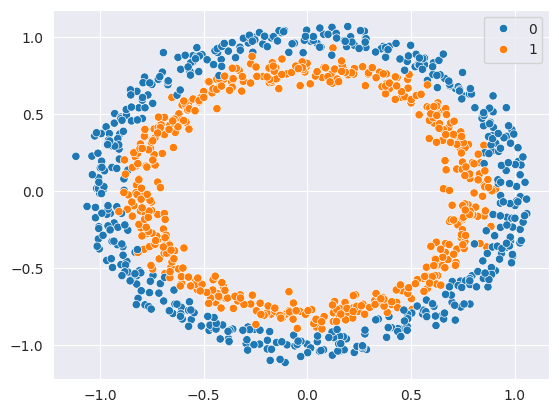

In [31]:
sns.scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=y,
)
plt.show()

# Train, Val, Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [33]:
# convert to torch.tensor
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [34]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} with shape: {X_sample.shape}')
print(f'Values for one sample of y: {y_sample} with shape: {y_sample.shape}')

Values for one sample of X: [0.74220688 0.24668576] with shape: (2,)
Values for one sample of y: 1 with shape: ()


# Build Model

In [35]:
device

device(type='cuda')

In [36]:
# 1. Create model
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 64)
        self.bn_1 = nn.BatchNorm1d(64)

        self.layer_2 = nn.Linear(64, 64)
        self.bn_2 = nn.BatchNorm1d(64)

        self.layer_3 = nn.Linear(64, 64)
        self.bn_3 = nn.BatchNorm1d(64)

        self.layer_4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.bn_1(x)
        x = torch.relu(x)

        x = self.layer_2(x)
        x = self.bn_2(x)
        x = torch.relu(x)

        x = self.layer_3(x)
        x = self.bn_3(x)
        x = torch.relu(x)

        x = self.layer_4(x)
        return x


def reset_initial_values(model, weight_value=0.01, bias_value=0.01):
    """
    This function resets the model's weights and biases to the provided values.
    """
    # Loop through all parameters in the model
    with torch.no_grad():  # Disable gradient calculation during reset
        for name, param in model.named_parameters():
            if 'weight' in name:
                param.fill_(weight_value)  # Reset weight
            elif 'bias' in name:
                param.fill_(bias_value)  # Reset bias
    return model

In [37]:
model_circle = Model().to(device)

# Make Predictions

In [38]:
model_circle.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
  

## Train Models

In [39]:

# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [40]:
# Start time
start_time = time.time()


def train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        epochs=10000,
        lr=0.001,
        patience=.05,
        min_delta=0.0001,
        batch_size=32768):
    # set the manual seed for reproducibility
    torch.manual_seed(42)

    # -------------------- Logging Params --------------------
    logger.info("Started MLflow run with actual run_id.")

    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("patience", patience)
    mlflow.log_param("min_delta", min_delta)
    mlflow.log_param("loss_fn", "BCEWithLogitsLoss")
    mlflow.log_param("optimizer", "SGD")

    # -------------------- Setup --------------------
    loss_fn = nn.BCEWithLogitsLoss()

    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

    train_losses = []
    eval_losses = []
    epoch_weights = []
    epoch_biases = []

    best_loss = float('inf')
    epoch = int
    best_epoch = 0
    trigger_times = 0

    # -------------------- Training Loop --------------------
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0

        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        if epoch == 0:
            print(f"[DEBUG] Initial loss (should be >= 0): {loss.item():.6f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss)

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val)
            eval_losses.append(val_loss.item())

            for name, param in model.named_parameters():
                if 'weight' in name:
                    epoch_weights.append(param.detach().cpu().numpy().mean())
                elif 'bias' in name:
                    epoch_biases.append(param.detach().cpu().numpy().mean())

            if val_loss.item() < best_loss - min_delta:
                best_loss = val_loss.item()
                best_epoch = epoch
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= patience * epochs:
                    print("🛑 Early stopping triggered.")
                    break

        scheduler.step(val_loss)

        if epoch % 1000 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f'{epoch:4} | Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | LR: {current_lr:.6f}')

    # -------------------- Logging Final Metrics --------------------
    mlflow.log_metric("best_val_loss", best_loss)
    mlflow.log_metric("best_epoch", best_epoch)
    mlflow.log_metric("epoch", epoch)

    # -------------------- MLflow Signature and Example --------------------
    df_sample = df_circles.sample(n=1000, random_state=42)
    timestamp = dt.datetime.now().strftime("%Y_%m_%d_%H%M%S")
    mlflow.log_input(from_pandas(df_sample, targets='y', name=f'circle_sample_{timestamp}'))

    input_example = X_train[:1].detach().cpu().numpy()
    device = next(model.parameters()).device
    input_tensor = torch.from_numpy(input_example).to(device)
    y_example = model(input_tensor).detach().cpu().numpy()
    signature = infer_signature(input_example, y_example)

    # -------------------- Saving the Model Artifact --------------------
    # log as full MLflow model (can be loaded later with mlflow.pytorch.load_model)
    mlflow.pytorch.log_model(model, "model", signature=signature, input_example=input_example)
    mlflow.end_run()

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.4f} seconds!")

    return {
        'train_losses': train_losses,
        'eval_losses': eval_losses,
        'epoch_weights': epoch_weights,
        'epoch_biases': epoch_biases,
        'best_loss': best_loss,
        'best_epoch': best_epoch,
        'trigger_times': trigger_times,
    }


In [41]:
if mlflow.active_run():
    mlflow.end_run()

# Train the Model
results = train_model(
    model=model_circle,
    X_train=X_train,
    y_train=y_train.float().unsqueeze(1),
    X_val=X_val,
    y_val=y_val.float().unsqueeze(1),
    epochs=100000,
    lr=0.001,
    patience=0.05,
    min_delta=0.0001,
    batch_size=32768,
)

🏃 View run gifted-doe-347 at: https://mlflow.example.internal/#/experiments/6/runs/b0f659e5c290426c84264f02ad33d252
🧪 View experiment at: https://mlflow.example.internal/#/experiments/6
[DEBUG] Initial loss (should be >= 0): 0.672449
   0 | Loss: 0.6724 | Val Loss: 0.6948 | LR: 0.001000
1000 | Loss: 0.0328 | Val Loss: 0.0423 | LR: 0.000001
2000 | Loss: 0.0324 | Val Loss: 0.0421 | LR: 0.000001
3000 | Loss: 0.0320 | Val Loss: 0.0418 | LR: 0.000001
4000 | Loss: 0.0314 | Val Loss: 0.0414 | LR: 0.000001
5000 | Loss: 0.0309 | Val Loss: 0.0411 | LR: 0.000001
6000 | Loss: 0.0304 | Val Loss: 0.0407 | LR: 0.000001
7000 | Loss: 0.0298 | Val Loss: 0.0403 | LR: 0.000001
8000 | Loss: 0.0293 | Val Loss: 0.0399 | LR: 0.000001
9000 | Loss: 0.0287 | Val Loss: 0.0397 | LR: 0.000001
10000 | Loss: 0.0282 | Val Loss: 0.0395 | LR: 0.000001
11000 | Loss: 0.0277 | Val Loss: 0.0392 | LR: 0.000001
12000 | Loss: 0.0272 | Val Loss: 0.0390 | LR: 0.000001
13000 | Loss: 0.0267 | Val Loss: 0.0387 | LR: 0.000001
14000 

In [42]:

# Training metrics log
logger.info("RESULT::LEARNING_STATS::" + json.dumps({
    "experiment": experiment_name,
    "epoch": results["best_epoch"],
    "best_loss": results["best_loss"],
    "trigger_times": results["trigger_times"],
}))

# Model state log
logger.info("RESULT::MODEL_STATE::" + json.dumps({
    "experiment": experiment_name,
    "final_weight_mean": str(results['epoch_weights'][results['best_epoch']]),
    "final_bias_mean": str(results['epoch_biases'][results['best_epoch']]),

}))




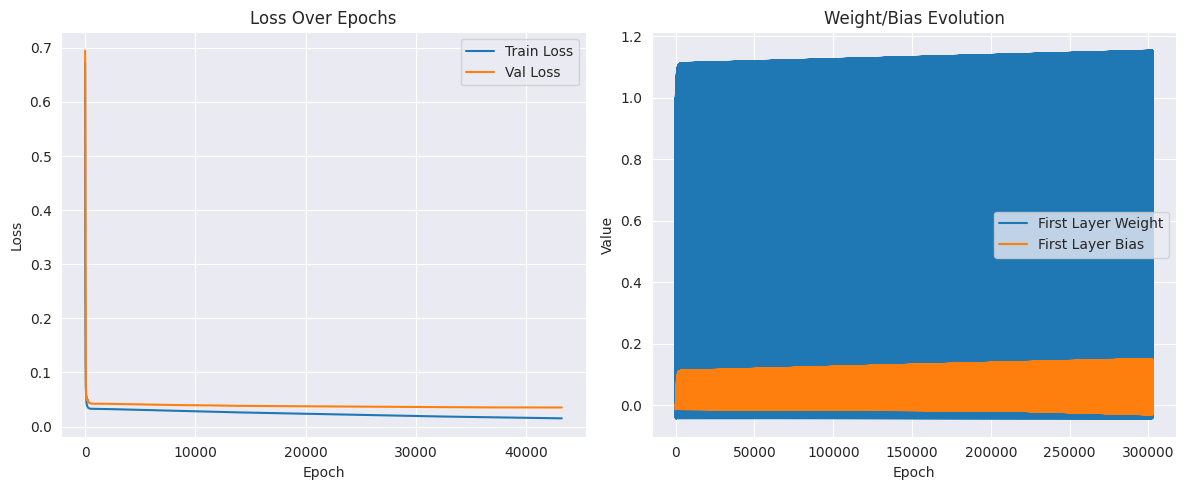

In [43]:
# Plot loss curves
plt.figure(figsize=(12, 5))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(results['train_losses'], label='Train Loss')
plt.plot(results['eval_losses'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Weights and Biases
plt.subplot(1, 2, 2)
plt.plot(results['epoch_weights'], label='First Layer Weight')
plt.plot(results['epoch_biases'], label='First Layer Bias')
plt.title("Weight/Bias Evolution")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()

plt.tight_layout()
plt.show()


[RESULT] Test Accuracy: 93.00%
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       100
           1       0.93      0.93      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



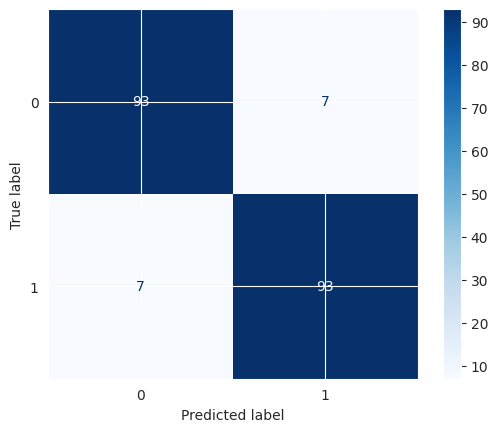

In [44]:
# Get Predictions
model_circle.eval()
with torch.no_grad():
    test_logits = model_circle(X_test)
    test_probs = torch.sigmoid(test_logits)
    test_preds = torch.round(test_probs).squeeze()

# Accuracy
test_accuracy = accuracy_fn(y_test.cpu(), test_preds.cpu())
print(f"[RESULT] Test Accuracy: {test_accuracy:.2f}%")

# Classification Report
print(classification_report(y_test.cpu(), test_preds.cpu()))

# Confusion Matrix
cm = confusion_matrix(y_test.cpu(), test_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


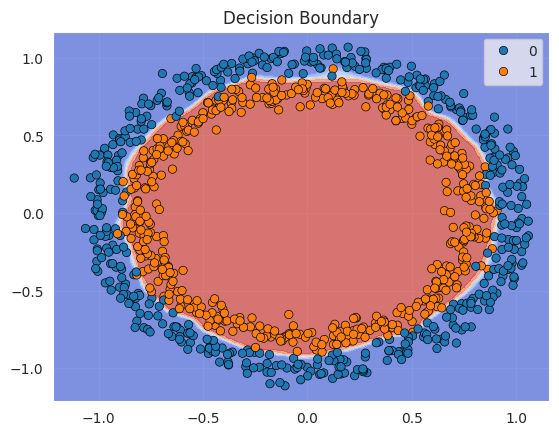

In [45]:
def plot_decision_boundary(model, X, y):
    model.eval()
    with torch.no_grad():
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))
        grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)
        probs = torch.sigmoid(model(grid)).reshape(xx.shape)
        plt.contourf(xx, yy, probs.cpu().numpy(), cmap='coolwarm', alpha=0.7)
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, edgecolor='k')
        plt.title("Decision Boundary")


# Call it
plot_decision_boundary(model_circle, X, y)
plt.show()


In [46]:
# Export to ONNX
onnx_path = f"/mnt/mls/models/torch/circles_model_{timestamp}.onnx"
torch.onnx.export(
    model_circle,
    args=X_test[:1],
    f=onnx_path,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11,
)

print(f"[INFO] Exported model to {onnx_path}")


[INFO] Exported model to /mnt/mls/models/torch/circles_model_2025_05_08_140258.onnx


# Register Model in MLFlow

In [47]:
result = mlflow.register_model(f"runs:/{run_id}/model", "circle_model")

client = mlflow.tracking.MlflowClient()
client.update_model_version(
    name="circle_model",
    version=result.version,
    description="Initial version registered by Gabe McWilliams from Udemy experiment."
)
client.set_registered_model_alias(
    name="circle_model",
    version=result.version,
    alias='Training',
)
client.set_model_version_tag(
    name="circle_model",
    version=result.version,
    key='created_by',
    value='gabe mcwilliams'
)

Registered model 'circle_model' already exists. Creating a new version of this model...
2025/05/08 07:03:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: circle_model, version 12
Created version '12' of model 'circle_model'.
